In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from itertools import product
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

### Setting inital data and parameters

In [2]:
START_DATE = '2024-01-01'
END_DATE = (datetime.now()+timedelta(days=-1)).strftime('%Y-%m-%d')
end_date_index = (datetime.now()+timedelta(days=-2)).strftime('%Y-%m-%d')
PRIMARY_PAIR = 'EURILS=X'

format_string = "%Y-%m-%d" # Specifies the format of the input strings

dt_obj1 = datetime.strptime(START_DATE, format_string)
dt_obj2 = datetime.strptime(END_DATE, format_string)

delta = dt_obj2 - dt_obj1

time_back_window = int(delta.days*0.05//1)
forecast = 182 # half year

In [3]:
df = yf.download(PRIMARY_PAIR, start=START_DATE, end=END_DATE, progress=False)
#df['rate'] = (df['Low']+df['High']+df['Open']+df['Close'])/4
#df['rate'] = (df['Low']+df['High'])/2
df['rate'] = df['High']
df = df[['rate']]
df

Price,rate
Ticker,
Date,
2024-01-01,3.971200
2024-01-02,4.010600
2024-01-03,4.000000
2024-01-04,4.005500
2024-01-05,4.044100
...,...
2025-12-19,3.764211
2025-12-22,3.773097


In [4]:
full_range = pd.date_range(start=START_DATE, end=end_date_index, freq='D')

df_full = df.reindex(full_range)
df_full = df_full.bfill()
df_full.index.name = 'date'
df_full = df_full.reset_index()
df=df_full
df = df.ffill()
df

Price,date,rate
Ticker,,
0,2024-01-01,3.971200
1,2024-01-02,4.010600
2,2024-01-03,4.000000
3,2024-01-04,4.005500
4,2024-01-05,4.044100
...,...,...
723,2025-12-24,3.761148
724,2025-12-25,3.768578
725,2025-12-26,3.768578


In [5]:
df_train = df[:-time_back_window]
df_train

Price,date,rate
Ticker,,
0,2024-01-01,3.971200
1,2024-01-02,4.010600
2,2024-01-03,4.000000
3,2024-01-04,4.005500
4,2024-01-05,4.044100
...,...,...
687,2025-11-18,3.814753
688,2025-11-19,3.801090
689,2025-11-20,3.782932


In [6]:
def calculate_optimal_cv_initial(data_length, forecast_horizon_days=30, target_folds=20, 
                                   min_ratio=3, max_initial_days=None):
        """
        Calculate optimal cv_initial that maximizes validation folds
        
        Parameters:
        -----------
        forecast_horizon_days : int
            Desired forecast horizon in days
        target_folds : int
            Target minimum number of validation folds (default: 20)
        min_ratio : float
            Minimum ratio of cv_initial to cv_horizon (default: 3)
        max_initial_days : int
            Maximum cv_initial in days (default: None = 80% of data)
            
        #Fold validations are (data_length - cv_initial) / forecast_horizon_days
        """
        
        # Constraints
        min_initial_seasonality = 400  # Need at least 1 year for yearly seasonality
        min_initial_ratio = forecast_horizon_days * min_ratio
        min_initial = max(min_initial_seasonality, min_initial_ratio)
        
        # Maximum initial: leave enough data for target_folds
        if max_initial_days is None:
            max_initial_days = int(data_length * 0.8)  # Use at most 80% for initial
        
        max_initial_from_folds = data_length - (forecast_horizon_days * target_folds)
        max_initial = min(max_initial_days, max_initial_from_folds)
        
        # Check if we have enough data
        if max_initial < min_initial:
            print("\n" + "="*70)
            print("⚠️  WARNING: Not enough data for target folds!")
            print("="*70)
            print(f"Data length: {data_length} days")
            print(f"Minimum cv_initial needed: {min_initial} days")
            print(f"Maximum cv_initial possible: {max_initial} days")
            print(f"Forecast horizon: {forecast_horizon_days} days")
        
        # Find optimal cv_initial that maximizes folds while respecting constraints
        # Start with minimum and check if we can achieve target folds
        max_folds = (data_length - min_initial) / forecast_horizon_days
        
        if max_folds >= target_folds:
            # We can achieve target folds, find the smallest initial that does so
            print(f"Found better option for maximum folds: {max_folds} with the min_initial")
        
        # Calculate final metrics
        cv_initial = max(min_initial,max_initial)
        actual_folds = (data_length - cv_initial) / forecast_horizon_days
        ratio = cv_initial / forecast_horizon_days
        
        # Display results
        print("\n" + "="*70)
        print("📊 Optimal Cross-Validation Parameters Calculated")
        print("="*70)
        print(f"Data length: {data_length} days ({data_length/365:.1f} years)")
        print(f"Forecast horizon: {forecast_horizon_days} days")
        print(f"\n✓ Optimal cv_initial: {cv_initial} days ({cv_initial/365:.1f} years)")
        print(f"  Ratio (initial:horizon): {ratio:.1f}:1")
        print(f"  Expected validation folds: {int(actual_folds)}")
        
        # Quality assessment
        print(f"\n📈 Quality Assessment:")
        if actual_folds >= target_folds:
            print(f"   ✓✓ Excellent! Achieved target of {target_folds}+ folds")
        elif actual_folds >= 15:
            print(f"   ✓ Very good! {int(actual_folds)} folds (target: {target_folds})")
        elif actual_folds >= 10:
            print(f"   ✓ Good! {int(actual_folds)} folds (target: {target_folds})")
        elif actual_folds >= 5:
            print(f"   ⚠️  Acceptable. {int(actual_folds)} folds (fewer than target {target_folds})")
        else:
            print(f"   ❌ Warning! Only {int(actual_folds)} folds - results may be unreliable")
        
        if ratio >= 10:
            print(f"   ✓✓ Excellent ratio ({ratio:.1f}:1)")
        elif ratio >= 4:
            print(f"   ✓ Good ratio ({ratio:.1f}:1)")
        elif ratio >= 3:
            print(f"   ⚠️  Minimum acceptable ratio ({ratio:.1f}:1)")
        else:
            print(f"   ❌ Ratio too small ({ratio:.1f}:1) - may miss patterns")
        
        print("="*70 + "\n")
        
        return cv_initial

In [7]:
cv_initial = calculate_optimal_cv_initial(data_length=len(df),forecast_horizon_days=time_back_window,target_folds=10)


⚠️  WARNING: Not enough data for target folds!
Data length: 728 days
Minimum cv_initial needed: 400 days
Maximum cv_initial possible: 368 days
Forecast horizon: 36 days

📊 Optimal Cross-Validation Parameters Calculated
Data length: 728 days (2.0 years)
Forecast horizon: 36 days

✓ Optimal cv_initial: 400 days (1.1 years)
  Ratio (initial:horizon): 11.1:1
  Expected validation folds: 9

📈 Quality Assessment:
   ⚠️  Acceptable. 9 folds (fewer than target 10)
   ✓✓ Excellent ratio (11.1:1)



In [8]:
cv_initial

400

In [10]:
class CurrencyForecaster:
    """
    Complete Prophet-based currency exchange rate forecasting system
    with hyperparameter tuning and comprehensive visualization
    """
    
    def __init__(self, df, date_col='date', value_col='rate'):
        """
        Initialize forecaster with currency data
        
        Parameters:
        -----------
        df : pandas DataFrame
            Currency data from Yahoo Finance
        date_col : str
            Name of the date column
        value_col : str
            Name of the exchange rate column (typically 'Close')
        """
        # Prepare data in Prophet format
        self.df = df[[date_col, value_col]].copy()
        self.df_train = df_train[[date_col, value_col]].copy()
        self.df.columns = ['ds', 'y']
        self.df['ds'] = pd.to_datetime(self.df['ds'])
        self.df = self.df.sort_values('ds').reset_index(drop=True)
        self.df_train.columns = ['ds', 'y']
        self.df_train['ds'] = pd.to_datetime(self.df_train['ds'])
        self.df_train = self.df_train.sort_values('ds').reset_index(drop=True)
        
        # Remove any NaN values
        self.df = self.df.dropna()
        self.df_train = self.df_train.dropna()
        
        print(f"Data loaded: {len(self.df)} records from {self.df['ds'].min()} to {self.df['ds'].max()}")
        print(f"Exchange rate range: {self.df['y'].min():.4f} to {self.df['y'].max():.4f}")
        
        print(f"Training Data: {len(self.df_train)} records from {self.df_train['ds'].min()} to {self.df_train['ds'].max()}")
        print(f"Exchange rate range: {self.df_train['y'].min():.4f} to {self.df_train['y'].max():.4f}")
        
        self.best_model = None
        self.best_params = None
        self.forecast = None
        
    def tune_hyperparameters(self, param_grid=None, cv_horizon='30 days', cv_initial='365 days'):
        """
        Perform grid search for best Prophet hyperparameters
        
        Parameters:
        -----------
        param_grid : dict
            Dictionary of parameters to tune
        cv_horizon : str
            Forecast horizon for cross-validation
        cv_initial : str
            Initial training period for cross-validation
        """
        if param_grid is None:
            # Default parameter grid for currency forecasting
            param_grid = {
                'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
                'seasonality_prior_scale': [0.01, 0.1, 1.0],
                'seasonality_mode': ['additive', 'multiplicative'],
                'changepoint_range': [0.9,0.95]
            }
        
        print("\n" + "="*60)
        print(f"Starting Hyperparameter Tuning on initial {cv_initial} with horizon of {cv_horizon}")
        print("="*60)
        
        # Generate all parameter combinations
        keys = param_grid.keys()
        values = param_grid.values()
        param_combinations = [dict(zip(keys, v)) for v in product(*values)]
        
        print(f"Testing {len(param_combinations)} parameter combinations...")
        
        results = []
        
        for i, params in enumerate(param_combinations, 1):
            try:
                # Train model with current parameters
                model = Prophet(**params, daily_seasonality=True, weekly_seasonality=True, 
                               yearly_seasonality=True)
                model.fit(self.df)
                
                # Cross-validation
                df_cv = cross_validation(model, initial=cv_initial, horizon=cv_horizon, 
                                        parallel="processes")
                df_metrics = performance_metrics(df_cv)
                
                # Store results
                mae = df_metrics['mae'].mean()
                rmse = df_metrics['rmse'].mean()
                mape = df_metrics['mape'].mean()
                
                results.append({
                    'params': params,
                    'mae': mae,
                    'rmse': rmse,
                    'mape': mape,
                    'score': mae  # Using MAE as primary metric
                })
                
                if i % 5 == 0:
                    print(f"Progress: {i}/{len(param_combinations)} - Current best MAE: {min(r['mae'] for r in results):.6f}")
                
            except Exception as e:
                print(f"Error with params {params}: {str(e)}")
                continue
        
        # Find best parameters
        best_result = min(results, key=lambda x: x['score'])
        self.best_params = best_result['params']
        
        print("\n" + "="*60)
        print("Hyperparameter Tuning Complete!")
        print("="*60)
        print(f"Best Parameters: {self.best_params}")
        print(f"Best MAE: {best_result['mae']:.6f}")
        print(f"Best RMSE: {best_result['rmse']:.6f}")
        print(f"Best MAPE: {best_result['mape']:.4f}%")
        
        return self.best_params, results
    
    def train_best_model(self, params=None):
        """
        Train the final model with best parameters
        
        Parameters:
        -----------
        params : dict
            Model parameters (uses self.best_params if None)
        """
        if params is None:
            if self.best_params is None:
                print("No tuned parameters found. Using default parameters.")
                params = {
                    'changepoint_prior_scale': 0.05,
                    'seasonality_prior_scale': 1.0,
                    'seasonality_mode': 'multiplicative',
                    'changepoint_range': 0.9
                }
            else:
                params = self.best_params
        
        print("\n" + "="*60)
        print("Training Final Model")
        print("="*60)
        
        self.best_model = Prophet(**params, daily_seasonality=True, 
                                 weekly_seasonality=True, yearly_seasonality=True)
        self.best_model.fit(self.df_train)
        
        print("Model trained successfully!")
        
        # Evaluate on training data
        in_sample_forecast = self.best_model.predict(self.df_train)
        mae = mean_absolute_error(self.df_train['y'], in_sample_forecast['yhat'])
        rmse = np.sqrt(mean_squared_error(self.df_train['y'], in_sample_forecast['yhat']))
        r2 = r2_score(self.df_train['y'], in_sample_forecast['yhat'])
        
        print(f"\nIn-sample Performance:")
        print(f"  MAE:  {mae:.6f}")
        print(f"  RMSE: {rmse:.6f}")
        print(f"  R²:   {r2:.4f}")
        
        return self.best_model
    
    def create_forecast(self, periods=182, freq='D'):
        """
        Generate future predictions
        
        Parameters:
        -----------
        periods : int
            Number of periods to forecast
        freq : str
            Frequency ('D' for daily, 'W' for weekly, 'M' for monthly)
        """
        if self.best_model is None:
            raise ValueError("Model not trained. Call train_best_model() first.")
        
        print(f"\nGenerating {periods}-period forecast...")
        
        future = self.best_model.make_future_dataframe(periods=periods, freq=freq)
        self.forecast = self.best_model.predict(future)
        
        # Show forecast summary
        future_only = self.forecast[self.forecast['ds'] > self.df_train['ds'].max()]
        print(f"\nForecast Summary:")
        print(f"  Forecast start: {future_only['ds'].min()}")
        print(f"  Forecast end:   {future_only['ds'].max()}")
        print(f"  Predicted range: {future_only['yhat'].min():.4f} to {future_only['yhat'].max():.4f}")
        
        return self.forecast
    
    def plot_trends(self, save_path=None):
        """
        Create comprehensive visualization suite
        
        Parameters:
        -----------
        save_path : str
            Path to save figures (optional)
        """
        if self.forecast is None:
            raise ValueError("No forecast available. Call create_forecast() first.")
        
        fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(15, 8))
        
        
        
        # Manually plot components
        forecast_data = self.forecast
        
        # Trend
        ax1.plot(forecast_data['ds'], forecast_data['trend'], color='blue', linewidth=2)
        ax1.set_title('Trend Component', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Trend', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Weekly seasonality
        if 'weekly' in forecast_data.columns:
            ax2.plot(forecast_data['ds'][:time_back_window], forecast_data['weekly'][:time_back_window], color='green', linewidth=2)
            ax2.set_title('Weekly Seasonality', fontsize=14, fontweight='bold')
            ax2.set_xlabel('Date', fontsize=12)
            ax2.set_ylabel('Weekly Effect', fontsize=12)
            ax2.grid(True, alpha=0.3)
        
        # Yearly seasonality
        if 'yearly' in forecast_data.columns:
            ax3.plot(forecast_data['ds'], forecast_data['yearly'], color='orange', linewidth=2)
            ax3.set_title('Yearly Seasonality', fontsize=14, fontweight='bold')
            ax3.set_xlabel('Date', fontsize=12)
            ax3.set_ylabel('Yearly Effect', fontsize=12)
            ax3.grid(True, alpha=0.3)    
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"\nPlots saved to {save_path}")
        
        plt.show()
    
    
    def plot_residuals(self):
        
        historical = self.forecast[self.forecast['ds'].isin(self.df['ds'])]
        residuals = self.df['y'].values - historical['yhat'].values
        plt.figure(figsize=(10, 8))
        plt.scatter(historical['ds'], residuals)
        plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
        plt.title("Residuals Regression")
        plt.xlabel("Date")
        plt.ylabel("Residual")
        plt.grid(True, alpha=0.3)
        plt.show()
        
    
    def _plot_forecast_distribution(self):
        """Plot distribution of future forecasted values"""
        future_only = self.forecast[self.forecast['ds'] > self.df['ds'].max()]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Histogram
        ax1.hist(future_only['yhat'], bins=30, alpha=0.7, color='blue', edgecolor='black')
        ax1.axvline(future_only['yhat'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f"Mean: {future_only['yhat'].mean():.4f}")
        ax1.set_title('Distribution of Forecasted Exchange Rates', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Exchange Rate', fontsize=12)
        ax1.set_ylabel('Frequency', fontsize=12)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot over time (monthly)
        future_only['month'] = future_only['ds'].dt.to_period('M')
        monthly_data = [group['yhat'].values for name, group in future_only.groupby('month')]
        months = [str(name) for name, _ in future_only.groupby('month')]
        
        ax2.boxplot(monthly_data, labels=months)
        ax2.set_title('Monthly Forecast Distribution', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Month', fontsize=12)
        ax2.set_ylabel('Exchange Rate', fontsize=12)
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def get_forecast_table(self, n_days=30):
        """
        Get forecast as a formatted table
        
        Parameters:
        -----------
        n_days : int
            Number of future days to display
        """
        future_only = self.forecast[self.forecast['ds'] > self.df['ds'].max()].head(n_days)
        
        result = future_only[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
        result.columns = ['Date', 'Forecast', 'Lower Bound', 'Upper Bound']
        result['Date'] = result['Date'].dt.date
        
        print(f"\n{'='*70}")
        print(f"Forecast Table - Next {n_days} Days")
        print('='*70)
        print(result.to_string(index=False))
        print('='*70)
        
        return result
    
    
    def plot_details(self,dayss=700):
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
        
        
        self.best_model.plot(self.forecast, ax=ax1)
        ax1.set_title('Exchange Rate Forecast with Uncertainty', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Date', fontsize=12)
        ax1.set_ylabel('Exchange Rate', fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        
        cutoff_date = self.df['ds'].max() - pd.Timedelta(days=dayss)
        recent_actual = self.df[self.df['ds'] >= cutoff_date]
        cutoff_date_pred = self.df_train['ds'].max()
        recent_actual_pred = self.df[self.df['ds'] >= cutoff_date_pred]
        recent_predictions = self.forecast[self.forecast['ds'].isin(recent_actual_pred['ds'])]
        future_forecast = self.forecast[self.forecast['ds'] > self.df['ds'].max()]
        
        ax2.plot(recent_actual['ds'], recent_actual['y'], color='black', label='Actual', linewidth=1)
        ax2.plot(recent_predictions['ds'], recent_predictions['yhat'], color='red', 
                label=f'Model Prediction (Last {time_back_window}d)', linewidth=2, alpha=0.7, zorder=2)
        ax2.plot(future_forecast['ds'], future_forecast['yhat'], 'b-', label='Forecast', linewidth=1)
        ax2.fill_between(future_forecast['ds'], 
                         future_forecast['yhat_lower'], 
                         future_forecast['yhat_upper'], 
                         alpha=0.3, color='blue', label='Uncertainty')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

### Training

In [11]:
forecaster = CurrencyForecaster(df, date_col='date', value_col='rate')

# Tune (takes 5-15 minutes depending on data size)
# Gives (Data - cv_initial) / cv_horizon fold validations
best_params, results = forecaster.tune_hyperparameters(cv_horizon=f'{time_back_window} days',cv_initial=f'{cv_initial} days')

Data loaded: 728 records from 2024-01-01 00:00:00 to 2025-12-28 00:00:00
Exchange rate range: 3.6915 to 4.2909
Training Data: 692 records from 2024-01-01 00:00:00 to 2025-11-22 00:00:00
Exchange rate range: 3.6915 to 4.2909

Starting Hyperparameter Tuning on initial 400 days with horizon of 36 days
Testing 48 parameter combinations...


22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:55 - cmdstanpy - INFO - Chain [1] done processing
22:06:09 - cmdstanpy - INFO - Chain [1] start processing
22:06:10 - cmdstanpy - INFO - Chain [1] done processing
22:06:24 - cmdstanpy - INFO - Chain [1] start processing
22:06:25 - cmdstanpy - INFO - Chain [1] done processing
22:06:41 - cmdstanpy - INFO - Chain [1] start processing
22:06:41 - cmdstanpy - INFO - Chain [1] done processing
22:06:56 - cmdstanpy - INFO - Chain [1] start processing
22:06:56 - cmdstanpy - INFO - Chain [1] done processing


Progress: 5/48 - Current best MAE: 0.164933


22:07:12 - cmdstanpy - INFO - Chain [1] start processing
22:07:13 - cmdstanpy - INFO - Chain [1] done processing
22:07:29 - cmdstanpy - INFO - Chain [1] start processing
22:07:29 - cmdstanpy - INFO - Chain [1] done processing
22:07:46 - cmdstanpy - INFO - Chain [1] start processing
22:07:46 - cmdstanpy - INFO - Chain [1] done processing
22:08:04 - cmdstanpy - INFO - Chain [1] start processing
22:08:04 - cmdstanpy - INFO - Chain [1] done processing
22:08:31 - cmdstanpy - INFO - Chain [1] start processing
22:08:32 - cmdstanpy - INFO - Chain [1] done processing


Progress: 10/48 - Current best MAE: 0.164933


22:08:54 - cmdstanpy - INFO - Chain [1] start processing
22:08:54 - cmdstanpy - INFO - Chain [1] done processing
22:09:10 - cmdstanpy - INFO - Chain [1] start processing
22:09:10 - cmdstanpy - INFO - Chain [1] done processing
22:09:25 - cmdstanpy - INFO - Chain [1] start processing
22:09:26 - cmdstanpy - INFO - Chain [1] done processing
22:09:43 - cmdstanpy - INFO - Chain [1] start processing
22:09:43 - cmdstanpy - INFO - Chain [1] done processing
22:09:59 - cmdstanpy - INFO - Chain [1] start processing
22:10:00 - cmdstanpy - INFO - Chain [1] done processing


Progress: 15/48 - Current best MAE: 0.162765


22:10:15 - cmdstanpy - INFO - Chain [1] start processing
22:10:16 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:32 - cmdstanpy - INFO - Chain [1] done processing
22:10:46 - cmdstanpy - INFO - Chain [1] start processing
22:10:47 - cmdstanpy - INFO - Chain [1] done processing
22:11:01 - cmdstanpy - INFO - Chain [1] start processing
22:11:02 - cmdstanpy - INFO - Chain [1] done processing
22:11:16 - cmdstanpy - INFO - Chain [1] start processing
22:11:17 - cmdstanpy - INFO - Chain [1] done processing


Progress: 20/48 - Current best MAE: 0.127294


22:11:32 - cmdstanpy - INFO - Chain [1] start processing
22:11:33 - cmdstanpy - INFO - Chain [1] done processing
22:11:47 - cmdstanpy - INFO - Chain [1] start processing
22:11:48 - cmdstanpy - INFO - Chain [1] done processing
22:12:04 - cmdstanpy - INFO - Chain [1] start processing
22:12:05 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:23 - cmdstanpy - INFO - Chain [1] done processing
22:12:39 - cmdstanpy - INFO - Chain [1] start processing
22:12:41 - cmdstanpy - INFO - Chain [1] done processing


Progress: 25/48 - Current best MAE: 0.104219


22:12:59 - cmdstanpy - INFO - Chain [1] start processing
22:13:01 - cmdstanpy - INFO - Chain [1] done processing
22:13:21 - cmdstanpy - INFO - Chain [1] start processing
22:13:22 - cmdstanpy - INFO - Chain [1] done processing
22:13:41 - cmdstanpy - INFO - Chain [1] start processing
22:13:43 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:02 - cmdstanpy - INFO - Chain [1] done processing
22:14:19 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing


Progress: 30/48 - Current best MAE: 0.104219


22:14:38 - cmdstanpy - INFO - Chain [1] start processing
22:14:39 - cmdstanpy - INFO - Chain [1] done processing
22:14:57 - cmdstanpy - INFO - Chain [1] start processing
22:14:58 - cmdstanpy - INFO - Chain [1] done processing
22:15:15 - cmdstanpy - INFO - Chain [1] start processing
22:15:16 - cmdstanpy - INFO - Chain [1] done processing
22:15:33 - cmdstanpy - INFO - Chain [1] start processing
22:15:34 - cmdstanpy - INFO - Chain [1] done processing
22:15:51 - cmdstanpy - INFO - Chain [1] start processing
22:15:54 - cmdstanpy - INFO - Chain [1] done processing


Progress: 35/48 - Current best MAE: 0.104219


22:16:15 - cmdstanpy - INFO - Chain [1] start processing
22:16:18 - cmdstanpy - INFO - Chain [1] done processing
22:16:39 - cmdstanpy - INFO - Chain [1] start processing
22:16:40 - cmdstanpy - INFO - Chain [1] done processing
22:16:58 - cmdstanpy - INFO - Chain [1] start processing
22:16:59 - cmdstanpy - INFO - Chain [1] done processing
22:17:16 - cmdstanpy - INFO - Chain [1] start processing
22:17:17 - cmdstanpy - INFO - Chain [1] done processing
22:17:35 - cmdstanpy - INFO - Chain [1] start processing
22:17:36 - cmdstanpy - INFO - Chain [1] done processing


Progress: 40/48 - Current best MAE: 0.104219


22:17:53 - cmdstanpy - INFO - Chain [1] start processing
22:17:55 - cmdstanpy - INFO - Chain [1] done processing
22:18:12 - cmdstanpy - INFO - Chain [1] start processing
22:18:14 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:58 - cmdstanpy - INFO - Chain [1] start processing
22:19:00 - cmdstanpy - INFO - Chain [1] done processing
22:19:20 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing


Progress: 45/48 - Current best MAE: 0.104219


22:19:45 - cmdstanpy - INFO - Chain [1] start processing
22:19:47 - cmdstanpy - INFO - Chain [1] done processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:10 - cmdstanpy - INFO - Chain [1] done processing
22:20:33 - cmdstanpy - INFO - Chain [1] start processing
22:20:36 - cmdstanpy - INFO - Chain [1] done processing



Hyperparameter Tuning Complete!
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.9}
Best MAE: 0.104219
Best RMSE: 0.137366
Best MAPE: 0.0267%


### Best Model

In [12]:
# Train with best parameters
forecaster.train_best_model()

# Forecast forecast days ahead
forecaster.create_forecast(periods=forecast, freq='D')


Training Final Model


22:21:30 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully!

In-sample Performance:
  MAE:  0.029451
  RMSE: 0.036641
  R²:   0.9345

Generating 182-period forecast...

Forecast Summary:
  Forecast start: 2025-11-23 00:00:00
  Forecast end:   2026-05-23 00:00:00
  Predicted range: 3.6866 to 4.0665


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-01,4.100489,4.026316,4.118572,4.100489,4.100489,-0.026483,-0.026483,-0.026483,0.000268,...,0.000113,0.000113,0.000113,-0.026865,-0.026865,-0.026865,0.0,0.0,0.0,4.074006
1,2024-01-02,4.100751,4.025153,4.120893,4.100751,4.100751,-0.027235,-0.027235,-0.027235,0.000268,...,-0.002621,-0.002621,-0.002621,-0.024882,-0.024882,-0.024882,0.0,0.0,0.0,4.073516
2,2024-01-03,4.101012,4.029433,4.123876,4.101012,4.101012,-0.023437,-0.023437,-0.023437,0.000268,...,-0.000290,-0.000290,-0.000290,-0.023415,-0.023415,-0.023415,0.0,0.0,0.0,4.077575
3,2024-01-04,4.101274,4.032682,4.124874,4.101274,4.101274,-0.023018,-0.023018,-0.023018,0.000268,...,-0.000831,-0.000831,-0.000831,-0.022455,-0.022455,-0.022455,0.0,0.0,0.0,4.078256
4,2024-01-05,4.101536,4.035428,4.133799,4.101536,4.101536,-0.019363,-0.019363,-0.019363,0.000268,...,0.002352,0.002352,0.002352,-0.021983,-0.021983,-0.021983,0.0,0.0,0.0,4.082173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,2026-05-19,3.962013,3.321499,4.693561,3.294694,4.674589,0.019555,0.019555,0.019555,0.000268,...,-0.002621,-0.002621,-0.002621,0.021907,0.021907,0.021907,0.0,0.0,0.0,3.981568
870,2026-05-20,3.963067,3.289670,4.707063,3.292969,4.680968,0.023736,0.023736,0.023736,0.000268,...,-0.000290,-0.000290,-0.000290,0.023758,0.023758,0.023758,0.0,0.0,0.0,3.986803
871,2026-05-21,3.964120,3.308051,4.710158,3.284512,4.686155,0.025150,0.025150,0.025150,0.000268,...,-0.000831,-0.000831,-0.000831,0.025712,0.025712,0.025712,0.0,0.0,0.0,3.989270
872,2026-05-22,3.965174,3.319409,4.718516,3.278206,4.694742,0.030314,0.030314,0.030314,0.000268,...,0.002352,0.002352,0.002352,0.027694,0.027694,0.027694,0.0,0.0,0.0,3.995488


### Plots

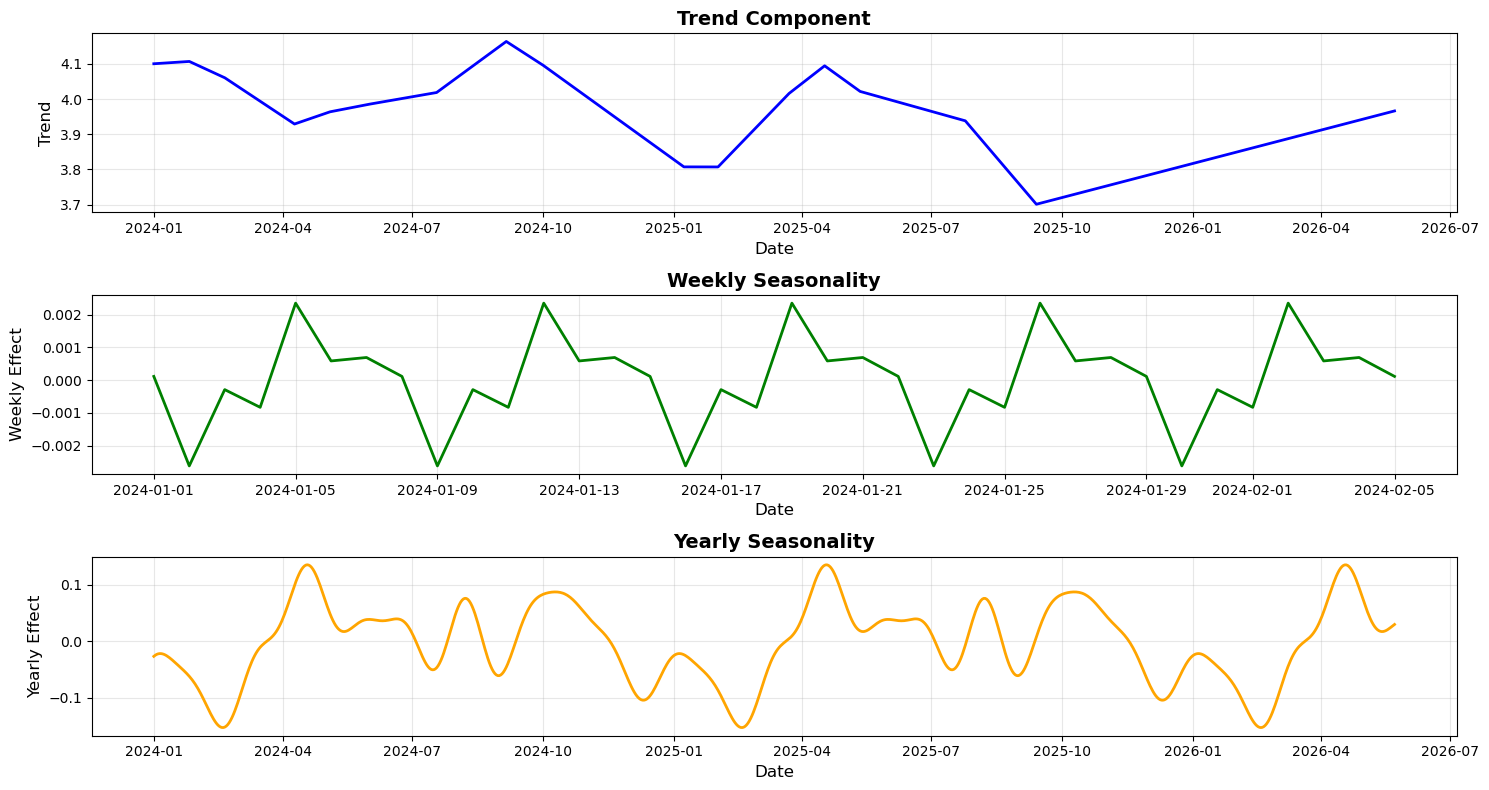

In [13]:
forecaster.plot_trends()

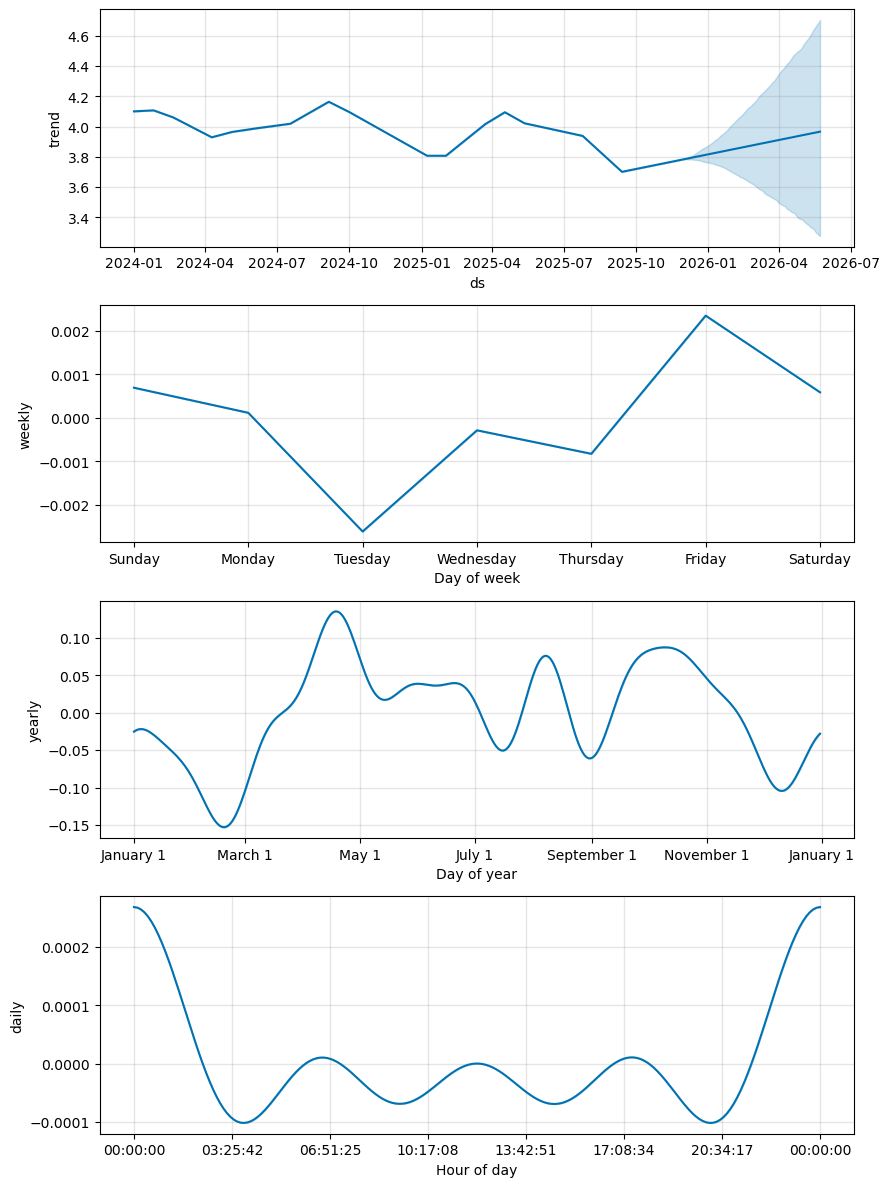

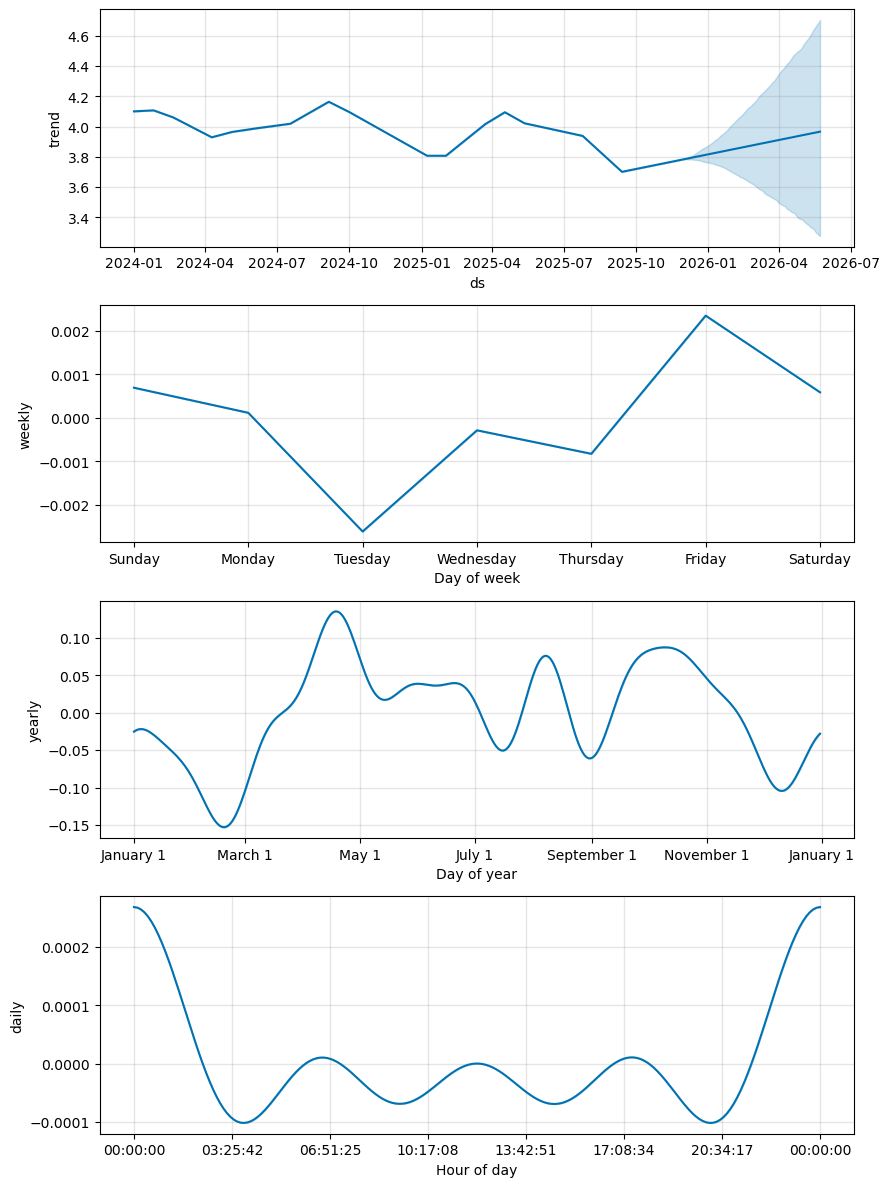

In [14]:
forecaster.best_model.plot_components(forecaster.forecast)

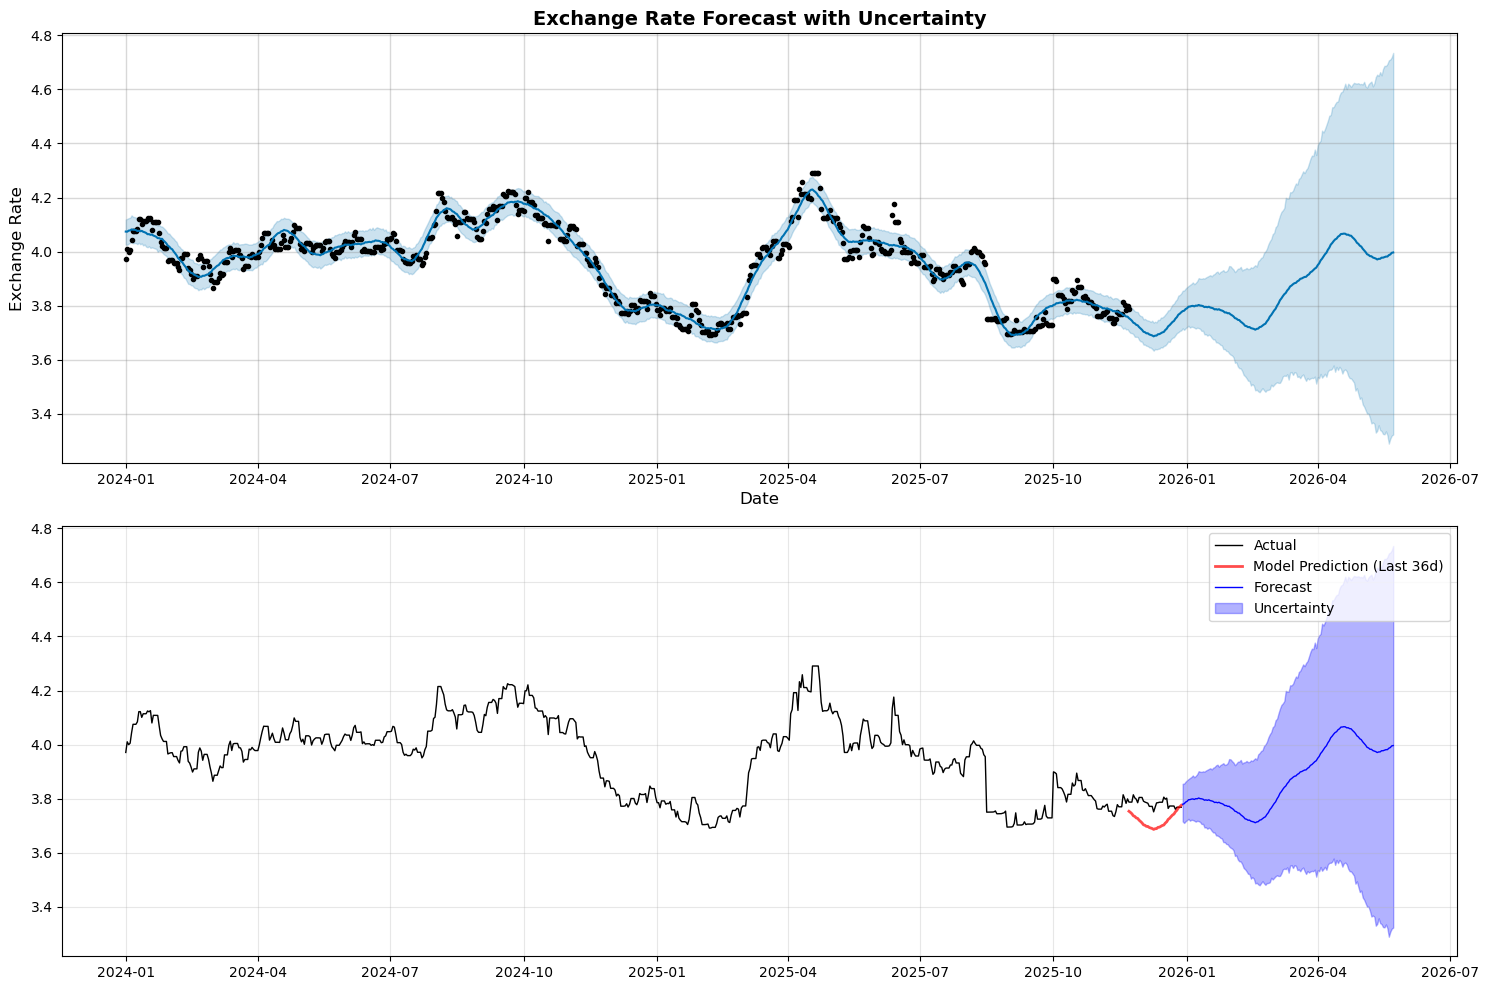

In [15]:
forecaster.plot_details(dayss=int(delta.days))

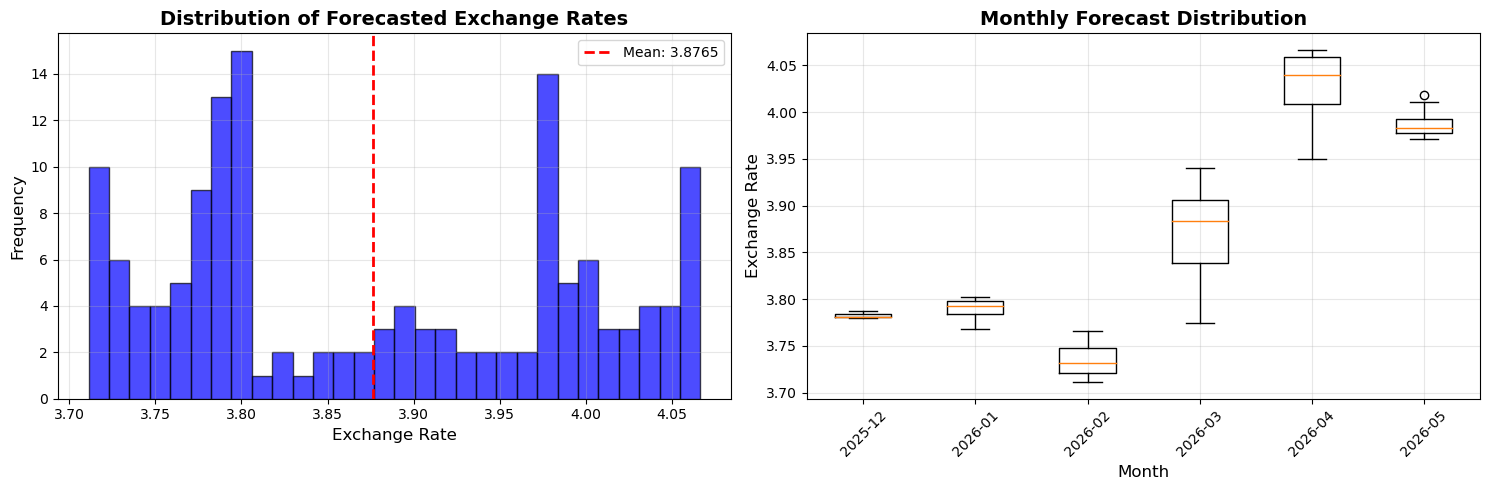

In [16]:
forecaster._plot_forecast_distribution()

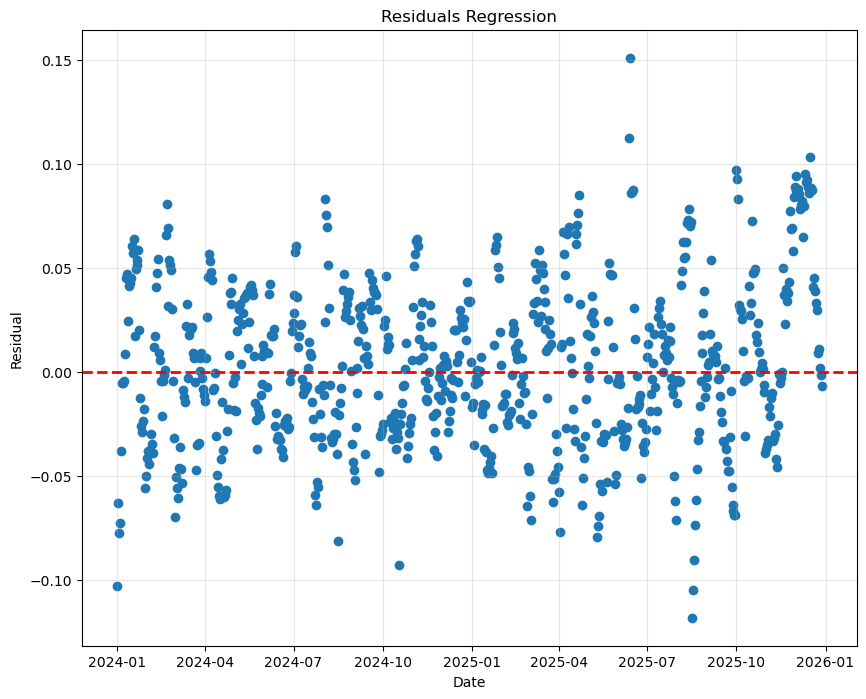

In [17]:
forecaster.plot_residuals()

In [18]:
forecaster.get_forecast_table(n_days=90)


Forecast Table - Next 90 Days
      Date  Forecast  Lower Bound  Upper Bound
2025-12-29  3.779805     3.716077     3.855218
2025-12-30  3.781369     3.710422     3.855975
2025-12-31  3.787505     3.716590     3.863099
2026-01-01  3.790259     3.720929     3.868292
2026-01-02  3.796219     3.725656     3.872685
2026-01-03  3.796718     3.718854     3.876634
2026-01-04  3.798590     3.722200     3.880580
2026-01-05  3.799305     3.721373     3.886047
2026-01-06  3.797421     3.718571     3.879453
2026-01-07  3.800198     3.715272     3.884160
2026-01-08  3.799744     3.718510     3.890717
2026-01-09  3.802698     3.717160     3.901865
2026-01-10  3.800438     3.714176     3.899923
2026-01-11  3.799830     3.706531     3.899142
2026-01-12  3.798365     3.707075     3.901402
2026-01-13  3.794612     3.693722     3.900293
2026-01-14  3.795830     3.694543     3.904278
2026-01-15  3.794113     3.689063     3.907019
2026-01-16  3.796080     3.693017     3.910001
2026-01-17  3.793075     3.68

,Date,Forecast,Lower Bound,Upper Bound
728,2025-12-29,3.779805,3.716077,3.855218
729,2025-12-30,3.781369,3.710422,3.855975
730,2025-12-31,3.787505,3.716590,3.863099
731,2026-01-01,3.790259,3.720929,3.868292
732,2026-01-02,3.796219,3.725656,3.872685
...,...,...,...,...
813,2026-03-24,3.906721,3.521752,4.302322
814,2026-03-25,3.912606,3.532578,4.308994
815,2026-03-26,3.915961,3.527153,4.325761
816,2026-03-27,3.923447,3.531074,4.342990
